In [1]:
import string

In [2]:
letters = string.ascii_letters + " .,;'-"
num_letters = len(letters)

In [3]:
letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-"

In [4]:
num_letters

58

In [5]:
import unicodedata

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
category_lines = {}
all_categories = []

In [9]:
files = !ls data/names/*.txt

In [10]:
files

['data/names/Arabic.txt',
 'data/names/Chinese.txt',
 'data/names/Czech.txt',
 'data/names/Dutch.txt',
 'data/names/English.txt',
 'data/names/French.txt',
 'data/names/German.txt',
 'data/names/Greek.txt',
 'data/names/Irish.txt',
 'data/names/Italian.txt',
 'data/names/Japanese.txt',
 'data/names/Korean.txt',
 'data/names/Polish.txt',
 'data/names/Portuguese.txt',
 'data/names/Russian.txt',
 'data/names/Scottish.txt',
 'data/names/Spanish.txt',
 'data/names/Vietnamese.txt']

In [11]:
import os

In [12]:
def readLines(file):
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [13]:
files[1][11:-4]

'Chinese'

In [14]:
for file in files:
    category = file[11:-4]
    all_categories.append(category)
    lines = readLines(file)
    category_lines[category] = lines

In [15]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [16]:
n_categories = len(all_categories)

In [17]:
n_categories

18

In [18]:
print(category_lines['Portuguese'][:5])

['Abreu', 'Albuquerque', 'Almeida', 'Alves', 'Araujo']


In [19]:
import torch
import torch.nn as nn

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories+input_size+hidden_size, hidden_size)
        
        self.i2o = nn.Linear(n_categories+input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [21]:
import random

In [22]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

In [23]:
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    
    return category, line

In [24]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    
    return tensor

In [25]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, num_letters)
    
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][letters.find(letter)] = 1
    
    return tensor

In [26]:
def targetTensor(line):
    letter_indexes = [letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(num_letters-1)
    
    return torch.LongTensor(letter_indexes)

In [27]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    
    return category_tensor, input_line_tensor, target_line_tensor

In [28]:
criterion = nn.NLLLoss()

In [29]:
learning_rate = 0.005

In [30]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

In [31]:
import time
import math

In [32]:
n_iters = 100000
print_every = 5000
plot_every = 500

In [37]:
total_loss = 0
all_losses = []

In [38]:
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m*60
    
    return '%dm %ds' % (m, s)

In [39]:
rnn = RNN(num_letters, 128, num_letters)

In [40]:
start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 2.2380
0m 24s (10000 10%) 2.2729
0m 36s (15000 15%) 2.6334
0m 48s (20000 20%) 2.2040
1m 0s (25000 25%) 2.3844
1m 12s (30000 30%) 1.5436
1m 24s (35000 35%) 2.5991
1m 37s (40000 40%) 2.1850
1m 50s (45000 45%) 1.9718
2m 4s (50000 50%) 2.5597
2m 16s (55000 55%) 2.0747
2m 29s (60000 60%) 3.9687
2m 41s (65000 65%) 2.1351
2m 54s (70000 70%) 2.2427
3m 6s (75000 75%) 2.6754
3m 19s (80000 80%) 2.0823
3m 32s (85000 85%) 2.1627
3m 44s (90000 90%) 2.3899
3m 57s (95000 95%) 2.0709
4m 9s (100000 100%) 2.1902


In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

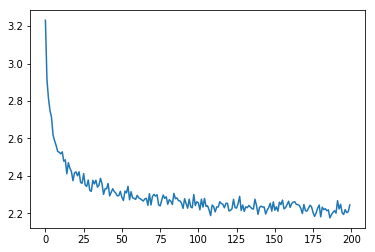

In [43]:
plt.figure()
plt.plot(all_losses)

In [41]:
max_length = 20

In [48]:
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == num_letters - 1:
                break
            else:
                letter = letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

In [49]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [54]:
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roviky
Untinov
Shimon
Gringer
Echerten
Romer
Sarara
Parraza
Abarra
Chu
Han
Ino
